In [1]:
# This cell is mandatory in all Dymos documentation notebooks.
missing_packages = []
try:
    import openmdao.api as om
except ImportError:
    if 'google.colab' in str(get_ipython()):
        !python -m pip install openmdao[notebooks]
    else:
        missing_packages.append('openmdao')
try:
    import dymos as dm
except ImportError:
    if 'google.colab' in str(get_ipython()):
        !python -m pip install dymos
    else:
        missing_packages.append('dymos')
try:
    import pyoptsparse
except ImportError:
    if 'google.colab' in str(get_ipython()):
        !pip install -q condacolab
        import condacolab
        condacolab.install_miniconda()
        !conda install -c conda-forge pyoptsparse
    else:
        missing_packages.append('pyoptsparse')
if missing_packages:
    raise EnvironmentError('This notebook requires the following packages '
                           'please install them and restart this notebook\'s runtime: {",".join(missing_packages)}')

# How can I more efficiently use finite-differenced components in the ODE?

Sometimes it's overly burdensome to get the analytic partials for a component.
In this case, OpenMDAO can use finite-differencing to approximate the partials of that component and then use those approximated partials when assembling the total derivatives.
However, if a dense sub-jacobian pattern is prescribed somewhere within the ODE, it will effect all dependent calculations and cause related total jacobians to have dense patterns.
In effect, a dense partial-derivative jacobian destroys the sparsity pattern of the problem.
To alleviate this, OpenMDAO provides a mechanism to [color the partials of a single component](http://openmdao.org/newdocs/versions/latest/features/experimental/simul_coloring_fd_cs.html).

As an example, consider the minimum time-to-climb problem.
The ODE of this problem consists of several components.
In this case, we're going to switch one of these components from using analytic derivatives to a finite-difference approximation.
Here we use an option on the component so that we can toggle the use of partial coloring on and off for testing, but that's not generally necessary.

In [2]:
om.display_source("dymos.examples.min_time_climb.doc.dynamic_pressure_comp_partial_coloring.DynamicPressureCompFD")

class DynamicPressureCompFD(om.ExplicitComponent):
    def initialize(self):
        self.options.declare('num_nodes', types=int)
        self.options.declare('partial_coloring', types=bool, default=False)

    def setup(self):
        nn = self.options['num_nodes']

        self.add_input(name='rho', shape=(nn,), desc='atmospheric density', units='kg/m**3')
        self.add_input(name='v', shape=(nn,), desc='air-relative velocity', units='m/s')

        self.add_output(name='q', shape=(nn,), desc='dynamic pressure', units='N/m**2')

        self.declare_partials(of='q', wrt='rho', method='fd')
        self.declare_partials(of='q', wrt='v', method='fd')

        if self.options['partial_coloring']:
            self.declare_coloring(wrt=['*'], method='cs', tol=1.0E-6, num_full_jacs=2,
                                  show_summary=True, show_sparsity=False, min_improve_pct=10.)

    def compute(self, inputs, outputs):
        outputs['q'] = 0.5 * inputs['rho'] * inputs['v'] ** 2

```{Note}
When using finite-differenced partials, they should not be specified in the `compute_partials` method. In fact, if all partials in the component are being approximated, `compute_partials` should just be omitted.
```

In this usage of `declare_coloring`, we use the following arguments:

- `wrt=['*']`
This is used to specify that we wish to find sparse partials **w**ith **r**espect **t**o all inputs.
- `method=['fd']`
We're using finite differencing to approximate the partials for coloring.
Using `'cs'` here (complex-step) will result in more accurate derivatives if the model supports the use of complex inputs.
- `tol=1.0E-6`
Any value in the Jacobian with a value greater than this will be considered a non-zero.
Since finite differencing is used and it generally encounters noise on the order of 1.0E-8, this tolerance should be larger than that.
If using complex-step for the approximation method this tolerance can be smaller - as small as about 1.0E-15.
- `num_full_jacs`
Compute the full jacobian this number of times before determining the partial sparsity pattern.
- `min_improve_pct`
If the number of solves required to compute the derivatives isn't reduced by at least this amount, then coloring is ignored and the dense jacobian is used.
- `show_summary = True`
Print the sparsity of the partial derivative jacobian.  This will display something like:

```
Jacobian shape: (60, 120)  ( 1.67% nonzero)
FWD solves: 2   REV solves: 0
Total colors vs. total size: 2 vs 120  (98.3% improvement)

Sparsity computed using tolerance: 1e-06
Time to compute sparsity: 0.011868 sec.
Time to compute coloring: 0.001385 sec.
```

- `show_sparsity=True`
Display the sparsity pattern in standard output to provide a visual indication whether or not it is working.
Here, this outputs the jacobian of `rho` with two diagonal bands - one for each of the two inputs.

```
Approx coloring for 'traj.phases.phase0.rhs_col.aero.q_comp' (class DynamicPressureCompFD)
f.............................f............................. 0  q
.f.............................f............................ 1  q
..f.............................f........................... 2  q
...f.............................f.......................... 3  q
....f.............................f......................... 4  q
.....f.............................f........................ 5  q
......f.............................f....................... 6  q
.......f.............................f...................... 7  q
........f.............................f..................... 8  q
.........f.............................f.................... 9  q
..........f.............................f................... 10  q
...........f.............................f.................. 11  q
............f.............................f................. 12  q
.............f.............................f................ 13  q
..............f.............................f............... 14  q
...............f.............................f.............. 15  q
................f.............................f............. 16  q
.................f.............................f............ 17  q
..................f.............................f........... 18  q
...................f.............................f.......... 19  q
....................f.............................f......... 20  q
.....................f.............................f........ 21  q
......................f.............................f....... 22  q
.......................f.............................f...... 23  q
........................f.............................f..... 24  q
.........................f.............................f.... 25  q
..........................f.............................f... 26  q
...........................f.............................f.. 27  q
............................f.............................f. 28  q
.............................f.............................f 29  q
|rho
                              |v
```

The sparsity patterns of the resulting total-derivative jacobian matrices are shown below.
Finite differencing without partial derivative coloring causes the sparsity pattern to be dense for a large portion of the matrix.
Since the dynamic pressure affects all of the defect constraints, the algorithm treats each defect constraint as if it is _potentially_ dependent upon all altitude and velocity values throughout the phase.
However, if partial derivative coloring is used, OpenMDAO recovers the same sparsity pattern as seen in the analytic derivative case.

In [3]:
from openmdao.utils.coloring import Coloring

def _view_coloring(coloring_file, show_sparsity_text=False, show_sparsity=True,
                   subjac_sparsity=False, color_var=None, show_meta=False):
    coloring = Coloring.load(coloring_file)
    if show_sparsity_text:
        coloring.display_txt()

    if show_sparsity:
        coloring.display()
        fig = plt.gcf()
        fig.set_size_inches(5.5, 5.5)
        fig.tight_layout()

    if subjac_sparsity:
        print("\nSubjacobian sparsity:")
        for tup in coloring._subjac_sparsity_iter():
            print("(%s, %s)\n   rows=%s\n   cols=%s" % tup[:4])
        print()

    if color_var is not None:
        fwd, rev = coloring.get_row_var_coloring(color_var)
        print("\nVar: %s  (fwd solves: %d,  rev solves: %d)\n" % (color_var, fwd, rev))

    if show_meta:
        print("\nColoring metadata:")
        pprint(coloring._meta)

    coloring.summary()

In [4]:
om.display_source("dymos.examples.min_time_climb.doc.min_time_climb_ode_partial_coloring.MinTimeClimbODE")

class MinTimeClimbODE(om.Group):

    def initialize(self):
        self.options.declare('num_nodes', types=int)
        self.options.declare('fd', types=bool, default=False, desc='If True, use fd for partials')
        self.options.declare('partial_coloring', types=bool, default=False,
                             desc='If True and fd is True, color the approximated partials')

    def setup(self):
        nn = self.options['num_nodes']

        self.add_subsystem(name='atmos',
                           subsys=USatm1976Comp(num_nodes=nn),
                           promotes_inputs=['h'])

        self.add_subsystem(name='aero',
                           subsys=AeroGroup(num_nodes=nn,
                                            fd=self.options['fd'],
                                            partial_coloring=self.options['partial_coloring']),
                           promotes_inputs=['v', 'alpha', 'S'])

        self.connect('atmos.sos', 'aero.sos')
        self.connect('atmos.rho', 'aero.rho')

        self.add_subsystem(name='prop',
                           subsys=PropGroup(num_nodes=nn),
                           promotes_inputs=['h', 'Isp', 'throttle'])

        self.connect('aero.mach', 'prop.mach')

        self.add_subsystem(name='flight_dynamics',
                           subsys=FlightPathEOM2D(num_nodes=nn),
                           promotes_inputs=['m', 'v', 'gam', 'alpha'])

        self.connect('aero.f_drag', 'flight_dynamics.D')
        self.connect('aero.f_lift', 'flight_dynamics.L')
        self.connect('prop.thrust', 'flight_dynamics.T')

In [5]:
%matplotlib inline


--- Constraint Report [traj] ---
    --- phase0 ---
        [final]   2.0000e+04 == h [m]
        [final]   1.0000e+00 == aero.mach [None]
        [final]   0.0000e+00 == gam [rad]
        [path]    1.0000e+02 <= h <= 2.0000e+04  [m]
        [path]    1.0000e-01 <= aero.mach <= 1.8000e+00  [None]

--------------------------------------------------------------------------------
--- Analytic derivatives in component ------------------------------------------
-------------------------------------------------------------------------------- 

Model viewer data has already been recorded for Driver.
Model viewer data has already been recorded for Driver.


/Users/rfalck/Codes/OpenMDAO.git/openmdao/core/driver.py:659: DriverWarning:The following design variable initial conditions are out of their specified bounds:
  traj.phase0.t_duration
    val: [500.]
    lower: 50.0
    upper: 400.0
Set the initial value of the design variable to a valid value or set the driver option['invalid_desvar_behavior'] to 'ignore'.


Full total jacobian for problem 'problem6' was computed 3 times, taking 0.16893545794300735 seconds.
Total jacobian shape: (361, 212) 


Jacobian shape: (361, 212)  (3.44% nonzero)
FWD solves: 13   REV solves: 0
Total colors vs. total size: 13 vs 212  (93.87% improvement)

Sparsity computed using tolerance: 1e-12
Time to compute sparsity:   0.1689 sec
Time to compute coloring:   0.1029 sec
Memory to compute coloring:   0.0000 MB
Coloring created on: 2024-08-14 08:50:56


/Users/rfalck/Codes/OpenMDAO.git/openmdao/core/total_jac.py:1646: DerivativesWarning:Constraints or objectives [('traj.phases.phase0->path_constraint->h', inds=[(0, 0)]), ('traj.phases.phase0->path_constraint->mach', inds=[(0, 0)])] cannot be impacted by the design variables of the problem.




Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    3.1586
       User Objective Time :       1.2243
       User Sensitivity Time :     1.1262
       Interface Time :            0.3350
       Opt Solver Time:            0.4730
    Calls to Objective Function :     131
    Calls to Sens Function :          107


   Objectives
      Index  Name                     Value
          0  traj.phase0.t     3.235052E+00

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name                            Type      Lower Bound            Value      Upper Bound     Status
          0  traj.phase0.t_duration_0           c     5.000000E-01     3.235052E+00     4.000000E+00           
          1  traj.phase0.states:r_0             c     0.000000E+00     1.808252E+00     1.000000E+03           
          2  traj.ph

/Users/rfalck/Codes/OpenMDAO.git/openmdao/utils/coloring.py:1326: OMDeprecationWarning:display is deprecated. Use display_bokeh for rich html displays of coloringor display_txt for a text-based display.


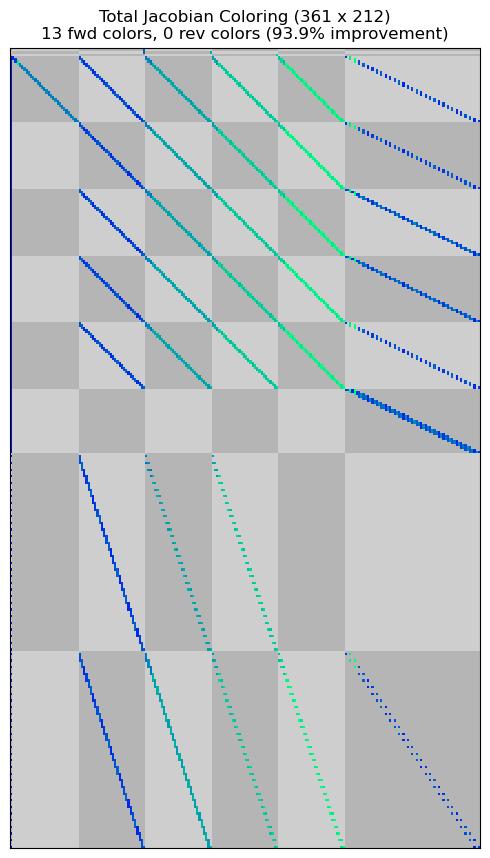


Jacobian shape: (361, 212)  (3.44% nonzero)
FWD solves: 13   REV solves: 0
Total colors vs. total size: 13 vs 212  (93.87% improvement)

Sparsity computed using tolerance: 1e-12
Time to compute sparsity:   0.1689 sec
Time to compute coloring:   0.1029 sec
Memory to compute coloring:   0.0000 MB
Coloring created on: 2024-08-14 08:50:56

--- Constraint Report [traj] ---
    --- phase0 ---
        [final]   2.0000e+04 == h [m]
        [final]   1.0000e+00 == aero.mach [None]
        [final]   0.0000e+00 == gam [rad]
        [path]    1.0000e+02 <= h <= 2.0000e+04  [m]
        [path]    1.0000e-01 <= aero.mach <= 1.8000e+00  [None]

--------------------------------------------------------------------------------
--- Finite differenced component -----------------------------------------------
-------------------------------------------------------------------------------- 

Model viewer data has already been recorded for Driver.
Model viewer data has already been recorded for Driver.


/Users/rfalck/Codes/OpenMDAO.git/openmdao/core/driver.py:659: DriverWarning:The following design variable initial conditions are out of their specified bounds:
  traj.phase0.t_duration
    val: [500.]
    lower: 50.0
    upper: 400.0
Set the initial value of the design variable to a valid value or set the driver option['invalid_desvar_behavior'] to 'ignore'.


Full total jacobian for problem 'problem7' was computed 3 times, taking 0.19410145794972777 seconds.
Total jacobian shape: (361, 212) 


Jacobian shape: (361, 212)  (23.30% nonzero)
FWD solves: 154   REV solves: 0
Total colors vs. total size: 154 vs 212  (27.36% improvement)

Sparsity computed using tolerance: 1e-12
Time to compute sparsity:   0.1941 sec
Time to compute coloring:   0.4864 sec
Memory to compute coloring:   2.9375 MB
Coloring created on: 2024-08-14 08:51:01


/Users/rfalck/Codes/OpenMDAO.git/openmdao/core/total_jac.py:1646: DerivativesWarning:Constraints or objectives [('traj.phases.phase0->path_constraint->h', inds=[(0, 0)]), ('traj.phases.phase0->path_constraint->mach', inds=[(0, 0)])] cannot be impacted by the design variables of the problem.




Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    9.5988
       User Objective Time :       1.5329
       User Sensitivity Time :     6.0089
       Interface Time :            0.4596
       Opt Solver Time:            1.5974
    Calls to Objective Function :     163
    Calls to Sens Function :          141


   Objectives
      Index  Name                     Value
          0  traj.phase0.t     3.235052E+00

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name                            Type      Lower Bound            Value      Upper Bound     Status
          0  traj.phase0.t_duration_0           c     5.000000E-01     3.235052E+00     4.000000E+00           
          1  traj.phase0.states:r_0             c     0.000000E+00     1.808251E+00     1.000000E+03           
          2  traj.ph

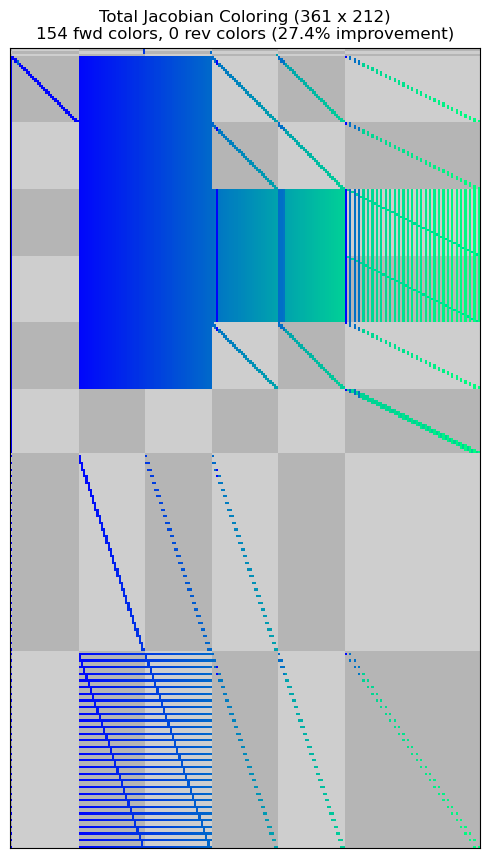


Jacobian shape: (361, 212)  (23.30% nonzero)
FWD solves: 154   REV solves: 0
Total colors vs. total size: 154 vs 212  (27.36% improvement)

Sparsity computed using tolerance: 1e-12
Time to compute sparsity:   0.1941 sec
Time to compute coloring:   0.4864 sec
Memory to compute coloring:   2.9375 MB
Coloring created on: 2024-08-14 08:51:01

--- Constraint Report [traj] ---
    --- phase0 ---
        [final]   2.0000e+04 == h [m]
        [final]   1.0000e+00 == aero.mach [None]
        [final]   0.0000e+00 == gam [rad]
        [path]    1.0000e+02 <= h <= 2.0000e+04  [m]
        [path]    1.0000e-01 <= aero.mach <= 1.8000e+00  [None]

--------------------------------------------------------------------------------
--- Finite differenced component with partial coloring -------------------------
-------------------------------------------------------------------------------- 

Model viewer data has already been recorded for Driver.
Model viewer data has already been recorded for Driver.


/Users/rfalck/Codes/OpenMDAO.git/openmdao/core/driver.py:659: DriverWarning:The following design variable initial conditions are out of their specified bounds:
  traj.phase0.t_duration
    val: [500.]
    lower: 50.0
    upper: 400.0
Set the initial value of the design variable to a valid value or set the driver option['invalid_desvar_behavior'] to 'ignore'.



Coloring for 'traj.phases.phase0.rhs_disc.aero.q_comp' (class DynamicPressureCompFD)

Jacobian shape: (60, 120)  (1.67% nonzero)
FWD solves: 2   REV solves: 0
Total colors vs. total size: 2 vs 120  (98.33% improvement)

Sparsity computed using tolerance: 1e-06
Time to compute sparsity:   0.0037 sec
Time to compute coloring:   0.0040 sec
Memory to compute coloring:   0.0000 MB

Coloring for 'traj.phases.phase0.rhs_col.aero.q_comp' (class DynamicPressureCompFD)

Jacobian shape: (30, 60)  (3.33% nonzero)
FWD solves: 2   REV solves: 0
Total colors vs. total size: 2 vs 60  (96.67% improvement)

Sparsity computed using tolerance: 1e-06
Time to compute sparsity:   0.0018 sec
Time to compute coloring:   0.0019 sec
Memory to compute coloring:   0.0000 MB
Full total jacobian for problem 'problem8' was computed 3 times, taking 0.19566941703669727 seconds.
Total jacobian shape: (361, 212) 


Jacobian shape: (361, 212)  (3.44% nonzero)
FWD solves: 13   REV solves: 0
Total colors vs. total size: 13

/Users/rfalck/Codes/OpenMDAO.git/openmdao/core/total_jac.py:1646: DerivativesWarning:Constraints or objectives [('traj.phases.phase0->path_constraint->h', inds=[(0, 0)]), ('traj.phases.phase0->path_constraint->mach', inds=[(0, 0)])] cannot be impacted by the design variables of the problem.




Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    3.5145
       User Objective Time :       1.2823
       User Sensitivity Time :     1.3879
       Interface Time :            0.3666
       Opt Solver Time:            0.4778
    Calls to Objective Function :     136
    Calls to Sens Function :          111


   Objectives
      Index  Name                     Value
          0  traj.phase0.t     3.235052E+00

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name                            Type      Lower Bound            Value      Upper Bound     Status
          0  traj.phase0.t_duration_0           c     5.000000E-01     3.235052E+00     4.000000E+00           
          1  traj.phase0.states:r_0             c     0.000000E+00     1.808252E+00     1.000000E+03           
          2  traj.ph

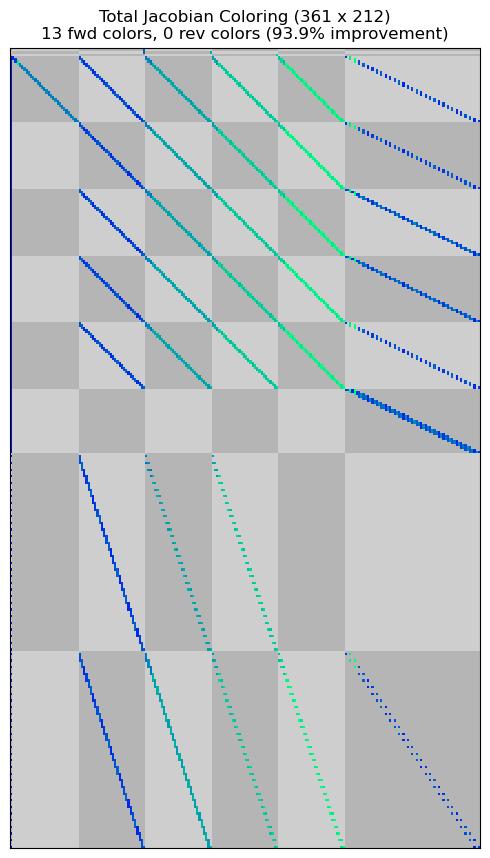


Jacobian shape: (361, 212)  (3.44% nonzero)
FWD solves: 13   REV solves: 0
Total colors vs. total size: 13 vs 212  (93.87% improvement)

Sparsity computed using tolerance: 1e-12
Time to compute sparsity:   0.1957 sec
Time to compute coloring:   0.1057 sec
Memory to compute coloring:   0.0781 MB
Coloring created on: 2024-08-14 08:51:12


<Figure size 550x550 with 0 Axes>

In [12]:
import os 
import matplotlib
import matplotlib.pyplot as plt
import shutil

import openmdao.api as om

import dymos as dm
from dymos.examples.min_time_climb.doc.min_time_climb_ode_partial_coloring import MinTimeClimbODE


for fd in (False, True):
    if fd:
        pc_options = (False, True)
    else:
        pc_options = (False,)
    for pc in pc_options:
        header = 'Finite differenced component' if fd else 'Analytic derivatives in component'
        header += ' with partial coloring' if pc else ''

        #
        # Instantiate the problem and configure the optimization driver
        #
        p = om.Problem(model=om.Group())

        p.driver = om.pyOptSparseDriver()
        p.driver.options['optimizer'] = 'IPOPT'
        
        p.driver.opt_settings['max_iter'] = 500
        p.driver.opt_settings['print_level'] = 0
        p.driver.opt_settings['nlp_scaling_method'] = 'gradient-based'
        p.driver.opt_settings['tol'] = 1.0E-6
        p.driver.opt_settings['mu_strategy'] = 'adaptive'
        p.driver.opt_settings['bound_mult_init_method'] = 'mu-based'
        p.driver.opt_settings['mu_init'] = 0.01
        
        p.driver.declare_coloring(tol=1.0E-12)

        #
        # Instantiate the trajectory and phase
        #
        traj = dm.Trajectory()

        phase = dm.Phase(ode_class=MinTimeClimbODE,
                         ode_init_kwargs={'fd': fd, 'partial_coloring': pc},
                         transcription=dm.GaussLobatto(num_segments=30))

        traj.add_phase('phase0', phase)

        p.model.add_subsystem('traj', traj)

        #
        # Set the options on the optimization variables
        #
        phase.set_time_options(fix_initial=True, duration_bounds=(50, 400),
                               duration_ref=100.0)

        phase.add_state('r', fix_initial=True, lower=0, upper=1.0E6,
                        ref=1.0E3, defect_ref=1.0E3, units='m',
                        rate_source='flight_dynamics.r_dot')

        phase.add_state('h', fix_initial=True, lower=0, upper=20000.0,
                        ref=1.0E2, defect_ref=1.0E2, units='m',
                        rate_source='flight_dynamics.h_dot')

        phase.add_state('v', fix_initial=True, lower=10.0,
                        ref=1.0E2, defect_ref=1.0E2, units='m/s',
                        rate_source='flight_dynamics.v_dot')

        phase.add_state('gam', fix_initial=True, lower=-1.5, upper=1.5,
                        ref=1.0, defect_ref=1.0, units='rad',
                        rate_source='flight_dynamics.gam_dot')

        phase.add_state('m', fix_initial=True, lower=10.0, upper=1.0E5,
                        ref=1.0E3, defect_ref=1.0E3, units='kg',
                        rate_source='prop.m_dot')

        phase.add_control('alpha', units='deg', lower=-8.0, upper=8.0, scaler=1.0,
                          rate_continuity=True, rate_continuity_scaler=100.0,
                          rate2_continuity=False, targets=['alpha'])

        phase.add_parameter('S', val=49.2386, units='m**2', opt=False, targets=['S'])
        phase.add_parameter('Isp', val=1600.0, units='s', opt=False, targets=['Isp'])
        phase.add_parameter('throttle', val=1.0, opt=False, targets=['throttle'])

        #
        # Setup the boundary and path constraints
        #
        phase.add_boundary_constraint('h', loc='final', equals=20000, scaler=1.0E-3)
        phase.add_boundary_constraint('aero.mach', loc='final', equals=1.0)
        phase.add_boundary_constraint('gam', loc='final', equals=0.0)

        phase.add_path_constraint(name='h', lower=100.0, upper=20000, ref=20000)
        phase.add_path_constraint(name='aero.mach', lower=0.1, upper=1.8)

        # Minimize time at the end of the phase
        phase.add_objective('time', loc='final', ref=100.0)

        p.model.options['assembled_jac_type'] = 'csc'
        p.model.linear_solver = om.DirectSolver(assemble_jac=True)

        #
        # Setup the problem and set the initial guess
        #
        p.setup()

        p['traj.phase0.t_initial'] = 0.0
        p['traj.phase0.t_duration'] = 500

        p['traj.phase0.states:r'] = phase.interp('r', [0.0, 50000.0])
        p['traj.phase0.states:h'] = phase.interp('h', [100.0, 20000.0])
        p['traj.phase0.states:v'] = phase.interp('v', [135.964, 283.159])
        p['traj.phase0.states:gam'] = phase.interp('gam', [0.0, 0.0])
        p['traj.phase0.states:m'] = phase.interp('m', [19030.468, 10000.])
        p['traj.phase0.controls:alpha'] = phase.interp('alpha', [0.0, 0.0])

        #
        # Solve for the optimal trajectory
        #
        
        print(80 * '-')
        print(f'{"--- " + header + " ":-<80}')
        print(80 * '-', '\n')
        dm.run_problem(p)

        #
        # This code is intended to save the coloring plots for the documentation.
        # In practice, use the command line interface to view these files instead:
        # `openmdao view_coloring coloring_files/total_coloring.pkl --view`
        #
        stfd = '_fd' if fd else ''
        stpc = '_pc' if pc else ''
        saved_coloring_dir = f'coloring_files{stfd}{stpc}'
        print(saved_coloring_dir)
        if os.path.exists(saved_coloring_dir):
            shutil.rmtree(saved_coloring_dir)
        shutil.move(p.get_coloring_dir(mode='output'), saved_coloring_dir)

        _view_coloring(os.path.join(saved_coloring_dir, 'total_coloring.pkl'));


In [ ]:
from openmdao.utils.assert_utils import assert_near_equal

#
# Test the results
#
assert_near_equal(p.get_val('traj.phase0.t_duration'), 321.0, tolerance=1.0E-1)

## Performance comparison

In this instance, the following performance was noted for the minimum time-to-climb case with 30 Gauss-Lobatto segments.
Using OpenMDAO's partial derivative coloring buys back a signficant amount of performance lost to finite differencing.
It should be noted that the IPOPT option `alpha_for_y` can have a signficant impact on performance here.
The default 'primal' step results in faster convergence for the sparse analytic case, but results in problematic convergence for the finite-differenced versions.
Switching the option using `p.driver.opt_settings['alpha_for_y'] = 'safer-min-dual-infeas'` results in a 'safer' step size and faster convergence of the finite-differenced versions, at the expense of some time in the analytic case.
The table below shows approximate run times normalized by the analytic version of the problem's run time.

| Derivative Type                  | Normalized Optimization Time |
|----------------------------------|------------------------------|
| Sparse Analytic                  | 1.0                          |
| Finite Difference (Dense)        | ~1.5 to ~2.5                 |
| Finite Difference (with Coloring)| ~1.0 to ~1.5                 |

Another note is that even in the finite differencing cases only a single component, the dynamic pressure component, is being switch to use finite differencing.
Doing so completely destroys the sparsity of the system, requiring over 10x as many solves of the resulting linear system to compute the total derivatives across the model.
This is an important lesson: **Failing to employ sparsity everywhere in a complex model can completely negate its benefit.** However, you can buy back a significant portion of this lost performance using partial coloring.